# Fashion MNIST - CNN Tuning

### Imports

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

## Business Understanding

### Load Data

In [2]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%
0.7%

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [3]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
test_set

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

9


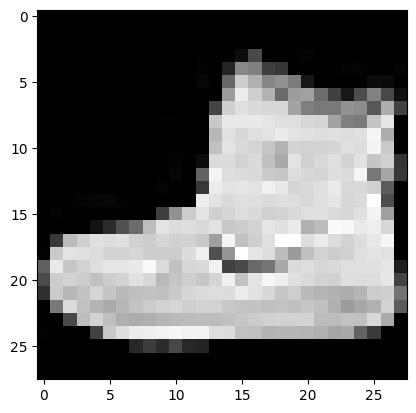

In [6]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

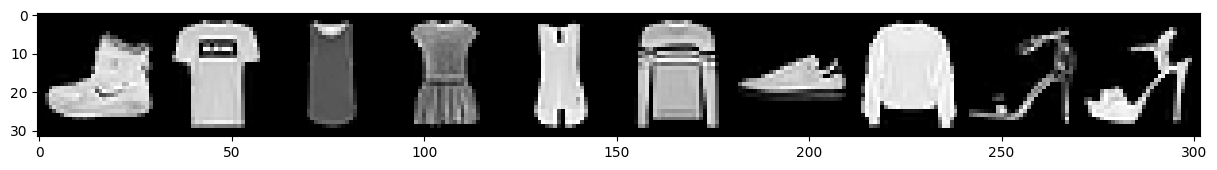

In [7]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [8]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

## Data Understanding

In [9]:
# Zugriff auf die Labels der Trainings- und Testdatensätze
train_labels = train_set.targets
test_labels = test_set.targets

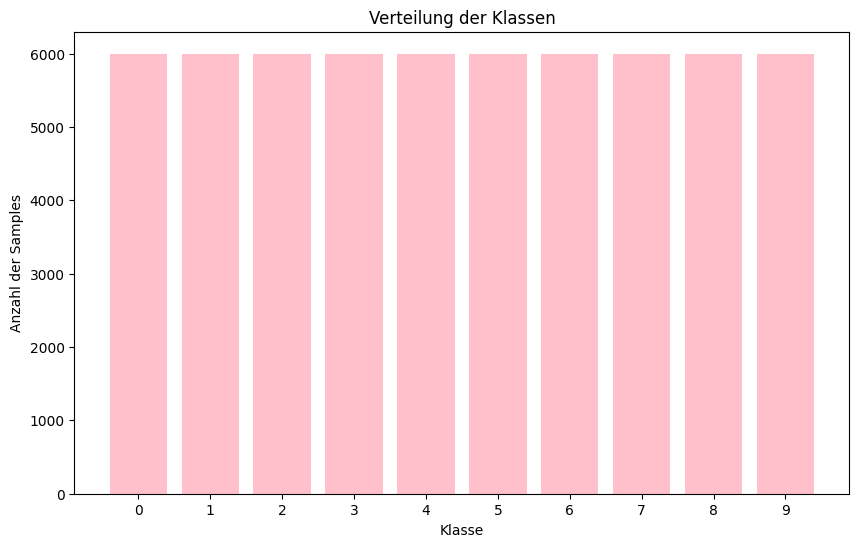

In [10]:
# Erstellen eines Pandas DataFrame, um die Klassenzuordnung und die Anzahl der Samples zu speichern
class_distribution = pd.DataFrame({'Class': np.arange(10), 'Count': np.bincount(train_labels)})

# Darstellen der Verteilung mit einem Balkendiagramm
plt.figure(figsize=(10, 6))
plt.bar(class_distribution['Class'], class_distribution['Count'], color='pink')
plt.xticks(class_distribution['Class'])
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Samples')
plt.title('Verteilung der Klassen')
plt.show()

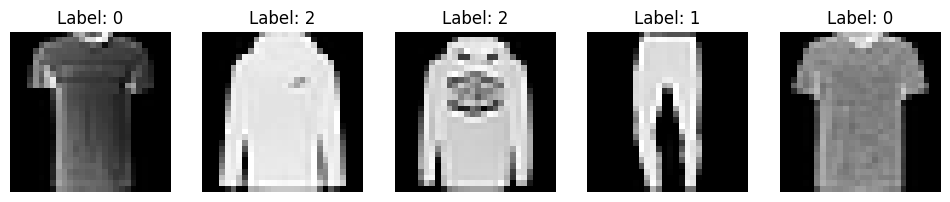

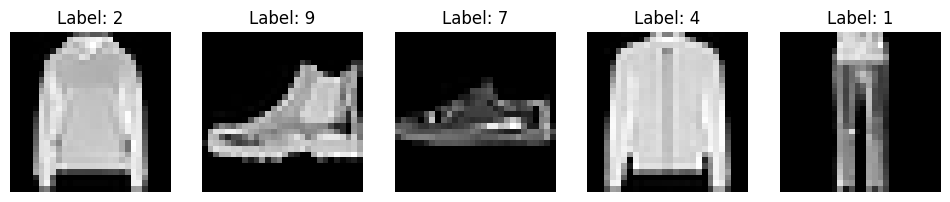

In [11]:
# Function to display random images with labels
def display_random_images(dataset, labels, num_images=5):
    # Generate random indices
    random_indices = np.random.randint(0, len(dataset), num_images)

    # Create a grid of subplots
    fig, axs = plt.subplots(1, num_images, figsize=(12, 6))

    # Display the random images with labels
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        axs[i].imshow(image.squeeze(), cmap='gray')  # Squeeze the image tensor to remove the channel dimension
        axs[i].set_title(f'Label: {label}')
        axs[i].axis('off')

    plt.show()

# Call the function to display 5 random images from the training set
display_random_images(train_set, train_labels, num_images=5)

# Call the function to display 5 random images from the test set
display_random_images(test_set, test_labels, num_images=5)

In [12]:
# Flatten the 2-dimensional images to 1-dimensional arrays
train_data = train_set.data.numpy().reshape(-1, 28 * 28)
test_data = test_set.data.numpy().reshape(-1, 28 * 28)

# Convert the datasets to DataFrames
train_df = pd.DataFrame(train_data, columns=[f"Pixel_{i}" for i in range(28 * 28)])
train_df["Label"] = pd.Series(train_set.targets.numpy())

test_df = pd.DataFrame(test_data, columns=[f"Pixel_{i}" for i in range(28 * 28)])
test_df["Label"] = pd.Series(test_set.targets.numpy())

# Display the head of the DataFrames (first few rows)
print(train_df.head())
print(test_df.head())

   Pixel_0  Pixel_1  Pixel_2  Pixel_3  Pixel_4  Pixel_5  Pixel_6  Pixel_7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        1        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   Pixel_8  Pixel_9  ...  Pixel_775  Pixel_776  Pixel_777  Pixel_778  \
0        0        0  ...          0          0          0          0   
1        0        0  ...        114        130         76          0   
2        0       22  ...          0          1          0          0   
3       33       96  ...          0          0          0          0   
4        0        0  ...          0          0          0          0   

   Pixel_779  Pixel_780  Pixel_781  Pixel_782  Pixel_783  Label  
0          0          0          0    

In [13]:
# Count the number of black pixels in each image
train_black_pixel_counts = np.sum(train_data == 0, axis=1)
test_black_pixel_counts = np.sum(test_data == 0, axis=1)

# Calculate the average number of black pixels across all images
train_avg_black_pixels = np.mean(train_black_pixel_counts)
test_avg_black_pixels = np.mean(test_black_pixel_counts)

print("Average black pixels in train images:", train_avg_black_pixels)
print("Average black pixels in test images:", test_avg_black_pixels)


Average black pixels in train images: 393.6083
Average black pixels in test images: 391.9183


In [14]:
import numpy as np
import pandas as pd


train_labels = train_set.targets.numpy()
test_labels = test_set.targets.numpy()

train_df = pd.DataFrame(train_data, columns=[f"Pixel_{i}" for i in range(28 * 28)])
train_df["Label"] = pd.Series(train_labels)

test_df = pd.DataFrame(test_data, columns=[f"Pixel_{i}" for i in range(28 * 28)])
test_df["Label"] = pd.Series(test_labels)

# Calculate the average number of black pixels per class
train_avg_black_pixels_per_class = train_df.groupby('Label').apply(lambda x: (x == 0).mean().mean())
test_avg_black_pixels_per_class = test_df.groupby('Label').apply(lambda x: (x == 0).mean().mean())

print("Average black pixels per class in train dataset:")
print(train_avg_black_pixels_per_class)

print("\nAverage black pixels per class in test dataset:")
print(test_avg_black_pixels_per_class)


Average black pixels per class in train dataset:
Label
0    0.406633
1    0.650493
2    0.350834
3    0.571363
4    0.397762
5    0.677994
6    0.370404
7    0.661229
8    0.413857
9    0.514823
dtype: float64

Average black pixels per class in test dataset:
Label
0    0.405772
1    0.646549
2    0.347526
3    0.566224
4    0.390775
5    0.677112
6    0.372101
7    0.661318
8    0.410748
9    0.515739
dtype: float64


## Data Preprocessing

In [16]:
# Define the size of your validation set (e.g., 20% of the training set)
validation_ratio = 0.2
dataset_size = len(train_set)
val_size = int(validation_ratio * dataset_size)
train_size = dataset_size - val_size

# Split the training dataset into training set and validation set
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

# Create data loaders for each dataset (training, validation, and test)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [17]:
train_loader

## Modelling

## Evaluation